In [1]:
# importing packages/modules

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sns.set_style('darkgrid')

Objective: Use unsupervised learning to create distinct clusters to represent the most abundant OTU(Operational taxonomic units)/identities of bacteria found in a mouse *Mus Musculus* based on schloss lab MiSeq standard operating procedures (SOPs).

In [2]:
# import the csv file into jupyter

df = pd.read_csv("0.16.cons.taxonomy.csv", delimiter=";",index_col=0, usecols=["otu","size","identity","phylum","class","order","family","genus","genus_0","genus_1"])

In [3]:
# look at the first couple of rows
df.head()

,size,identity,phylum,class,order,family,genus,genus_0,genus_1
otu,,,,,,,,,
Otu001,61864,Bacteria(100),Bacteroidetes(100),Bacteroidia(100),Bacteroidales(100),Porphyromonadaceae(100),Barnesiella(96),Barnesiella_unclassified(96),Barnesiella_unclassified(96)
Otu002,23360,Bacteria(100),Firmicutes(100),Clostridia(100),Clostridiales(100),Lachnospiraceae(89),Lachnospiraceae_unclassified(61),Lachnospiraceae_unclassified(61),Lachnospiraceae_unclassified(61)
Otu003,6679,Bacteria(100),Firmicutes(100),Bacilli(100),Lactobacillales(100),Lactobacillaceae(95),Lactobacillus(95),Lactobacillus_unclassified(95),Lactobacillus_unclassified(95)
Otu004,6584,Bacteria(100),Bacteroidetes(100),Bacteroidia(100),Bacteroidales(100),Bacteroidaceae(100),Bacteroides(100),Bacteroides_unclassified(100),Bacteroides_unclassified(100)
Otu005,5376,Bacteria(100),Bacteroidetes(100),Bacteroidia(100),Bacteroidales(100),Rikenellaceae(100),Alistipes(100),Alistipes_unclassified(100),Alistipes_unclassified(100)


In [4]:
# give a concise summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, Otu001 to Otu106
Data columns (total 9 columns):
size        106 non-null int64
identity    106 non-null object
phylum      106 non-null object
class       106 non-null object
order       106 non-null object
family      106 non-null object
genus       106 non-null object
genus_0     106 non-null object
genus_1     106 non-null object
dtypes: int64(1), object(8)
memory usage: 8.3+ KB


In [5]:
# changing the type of the column to int32 to reduce memory usage 
# the other columns are of the right type

df['size'] = df['size'].astype('int32')

In [6]:
# check for NaNs or missing values

missing = sum(pd.isnull(df).any())

msg = 'They are {} missing values in this data set.'

print(msg.format(missing))

They are 0 missing values in this data set.


In [7]:
# subsetting the dataframe taking only the phylum columns
phylum = df['phylum']

# counting each category 
phylum.value_counts()

Firmicutes(100)               54
Proteobacteria(100)           14
TM7(100)                      12
Bacteria_unclassified(100)    10
Bacteroidetes(100)             7
Actinobacteria(100)            4
Deinococcus-Thermus(100)       4
Verrucomicrobia(100)           1
Name: phylum, dtype: int64

We have a lot of Firmicues and Proteobacteria. Usually it's **Firmicutes** and **Bacteriodetes** in healthy humans (debatable depends on a lot of factors). Let's change the strings in the columns to numbers using a cool trick with DictVectorizer. For unsupervised learning techniques to work; you need a matrix: rows and columns with numbers.

In [8]:
# Make a boolean mask for categorical columns
df_mask = (df.dtypes == object)

# Get list of categorical column names
df_mask_columns = df.columns[df_mask].tolist()

# conversion of dataframe to dictionary 
df_dict = df.to_dict("records")

# We don't want  sparse matrices
dv = DictVectorizer(sparse = False)

In [9]:
# Apply fit_transform to our dataset
df_encoded = dv.fit_transform(df_dict)

# New column names
print(dv.vocabulary_)

{'genus=Rhizobiales_unclassified(100)': 94, 'family=Erysipelotrichaceae(100)': 34, 'genus=Bacteroidetes_unclassified(100)': 70, 'order=Bacteroidetes_unclassified(100)': 212, 'genus=Bacteroides(100)': 69, 'family=Lactobacillaceae(95)': 40, 'genus_0=Cryomorphaceae_unclassified(100)': 128, 'genus_1=Bacillales_unclassified(100)': 163, 'genus_1=Firmicutes_unclassified(100)': 181, 'genus_1=unclassified_Clostridiales_unclassified(93)': 203, 'genus_0=Turicibacter_unclassified(100)': 150, 'genus_1=Clostridiales_unclassified(69)': 174, 'order=Neisseriales(100)': 224, 'genus_1=Rhizobiales_unclassified(100)': 192, 'genus_0=Rhizobiales_unclassified(100)': 142, 'genus=Bacilli_unclassified(100)': 66, 'order=Clostridia_unclassified(100)': 214, 'genus=Acinetobacter(100)': 58, 'genus_1=Adlercreutzia(64)': 157, 'genus_1=Staphylococcus_unclassified(100)': 196, 'genus_0=Firmicutes_unclassified(100)': 132, 'class=Erysipelotrichi(100)': 10, 'genus=Stenotrophomonas(100)': 99, 'family=Cryomorphaceae(100)': 31,

In [10]:
# rows and number of column names in the matrix
# 106 rows and 240 columns
df_encoded.shape

(106, 240)

In [11]:
# t-SNE
# find a two dimensional representation of the data that preserves the distances between points as best as possible
# preserves information by finding the closest neighbours (points)

# instantiate model
tsne = TSNE(random_state=42)

# fit and transform the data
otu_tsne = tsne.fit_transform(df_encoded)

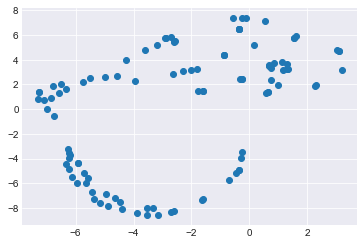

In [12]:
# plot 
xs = otu_tsne[:,0]
ys = otu_tsne[:,1]
plt.scatter(xs, ys)
plt.show()

The clusters are not so distinct maybe changing the *learning rate* parameter could help. Let's apply another technique and see how this gones. Prinicipal Component analysis(PCoA), however, Principal Coordinate analysis would be more in this case.

In [13]:
# PCA removes the zero variance features and transforms the data
# Another cool thing about PCA is that you can use it for feature extraction

stdscale = StandardScaler() # use a standard scaler to ensure each row has a mean of 0 and a variance of 1
df_scaled = stdscale.fit_transform(df_encoded) # apply it to our dataset

In [14]:
# call PCA
model_pca = PCA()
transformed = model_pca.fit_transform(df_scaled) #fit
print(transformed.shape) # look at the dimensions of the matrix

(106, 106)


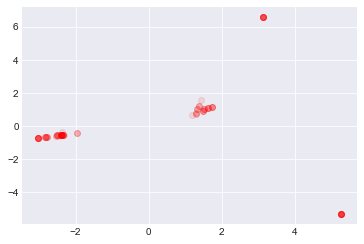

In [15]:
# draw a scatter plot of the first two columns, change the transparency of the points and draw the points in red
plt.scatter(transformed[:,0], transformed[:,1], alpha = 0.1, color = 'red')

Text(0.5,1,'Finding the ideal number of n_components parameter for PCA')

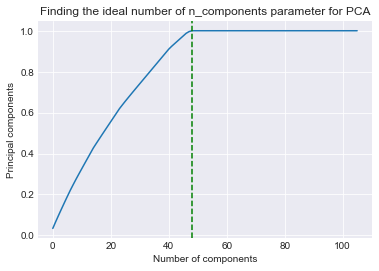

In [16]:
# Plot explained total variance of principal components against number of components
# make a vertical line to ensure you are extracting the right point on the graph

plt.plot(np.cumsum(model_pca.explained_variance_ratio_))
plt.axvline(x=48, color='green', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Principal components')
plt.title('Finding the ideal number of n_components parameter for PCA')

(106, 106)


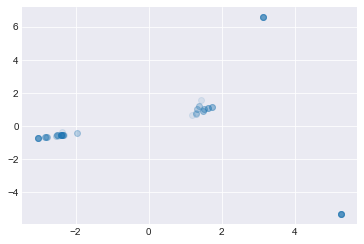

In [17]:
# new fit
# Let's try adjust the number of components and see what we'll get
pca = PCA(n_components=48)
transformed = model_pca.fit_transform(df_scaled)
print(transformed.shape)
plt.scatter(transformed[:,0], transformed[:,1], alpha = 0.1)

In [18]:
phylum.value_counts()

Firmicutes(100)               54
Proteobacteria(100)           14
TM7(100)                      12
Bacteria_unclassified(100)    10
Bacteroidetes(100)             7
Actinobacteria(100)            4
Deinococcus-Thermus(100)       4
Verrucomicrobia(100)           1
Name: phylum, dtype: int64

From the results, i suspect that the points between 0 and 2 *x-axis* and 0 and 2 *y-axis* could represent the bacteria which are on the phylum **Firmicutes** to left could be the **Proteobacteria**. Whereas, the isolated points could be **TM7** and **Bacteria_unclassified**. I've achieved partially achieved my objective with this dataset. Later on, I'll run PCoA on this dataset and compare the results. In addition, if you choose another part of the matrix you'll get a different result. 